In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import warnings
import datetime

# import categorical api 
from pandas.api.types import CategoricalDtype
from scipy.stats import chi2_contingency

#warnings.filterwarnings("ignore")

In [2]:
file = open('../../conf/global_conf.yml', 'r') 
conf = yaml.safe_load(file)
data_cleaned = pd.read_csv(conf['local_data_path'] + "data_cleaned_final.csv",index_col=0,low_memory=False)

# Tests du chi-2 d'indépendance du chi 2 et V de Cramer

In [3]:
liste_stat = []
col_a_eliminer = ['grav', 'grav_rec', 'date', 'heure', 'lat', 'long']
for i in data_cleaned.columns.drop(col_a_eliminer):

    stat, p = chi2_contingency(pd.crosstab(data_cleaned["grav"], data_cleaned[i]))[:2]
    a = data_cleaned["grav"].nunique()
    b =  data_cleaned[i].nunique()

    V_Cramer = np.sqrt(stat/(pd.crosstab(data_cleaned["grav"], data_cleaned[i]).values.sum()*(np.min([a, b]) - 1)))

    liste_stat.append([i, stat, p, V_Cramer])

In [4]:
stat_tot = pd.DataFrame(liste_stat, columns=['nom_var', 'stat_chi2', 'p_value', 'V_cramer'])
stat_tot = stat_tot.set_index('nom_var')
stat_tot

stat_chi2        p_value  V_cramer
nom_var                                       
jour       115.472021   3.649673e-02  0.009278
mois       536.158532   3.336781e-92  0.019992
agg      12945.942201   0.000000e+00  0.170156
int       3347.392029   0.000000e+00  0.086523
atm         87.500705   7.538590e-19  0.013989
...               ...            ...       ...
col_3.0   4789.555503   0.000000e+00  0.103497
col_4.0   5614.779035   0.000000e+00  0.112059
col_5.0   1363.063680  3.047889e-295  0.055213
col_6.0   7086.923510   0.000000e+00  0.125895
col_7.0  11108.475914   0.000000e+00  0.157619

[92 rows x 3 columns]

Une p_value inférieure à 5% indique une relation entre les variables, tandis que le V cramer permet de quantifier l'intensité de la relation. Il est d'usage de considérer qu'en dessous d'une valeur de 0.1, la relation est nulle ou très faible

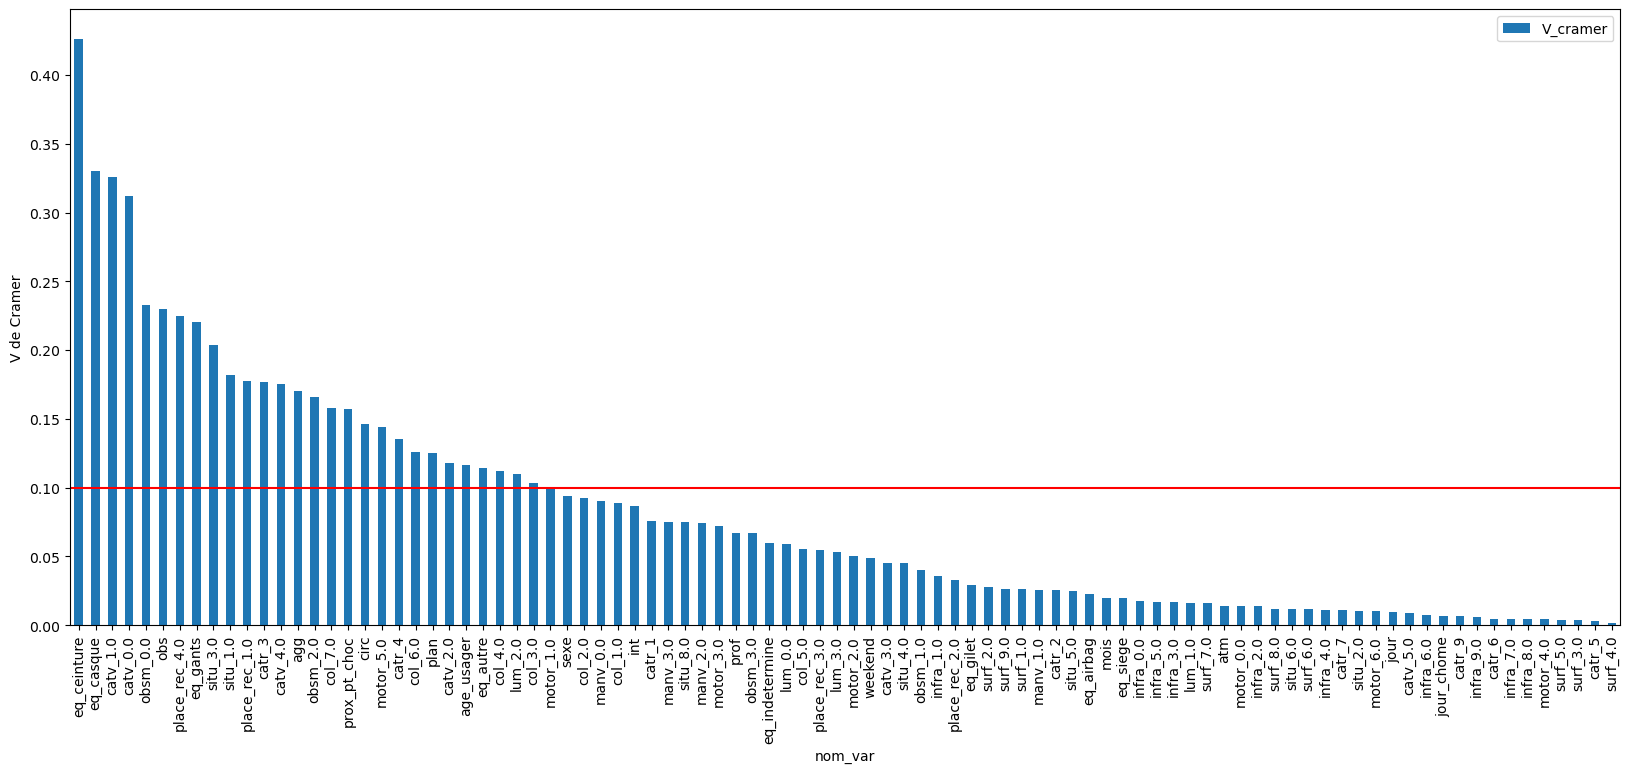

In [5]:
stat_tri = stat_tot.sort_values(by='V_cramer', ascending=False)
fix, ax = plt.subplots(figsize=(20,8));
stat_tri.plot.bar(y='V_cramer', ax=ax);
ax.set_ylabel('V de Cramer');
plt.axhline(y=0.1, c='r')


In [6]:
stat_tot[(stat_tot.p_value <= 0.05) & (stat_tot.V_cramer >= 0.1)].sort_values(by='V_cramer', ascending=False)

stat_chi2  p_value  V_cramer
nom_var                                       
eq_ceinture    81373.065052      0.0  0.426600
eq_casque      48749.157697      0.0  0.330190
catv_1.0       47452.506631      0.0  0.325769
catv_0.0       43567.253415      0.0  0.312148
obsm_0.0       24171.903576      0.0  0.232507
obs            23582.938602      0.0  0.229657
place_rec_4.0  22631.424444      0.0  0.224976
eq_gants       21807.639416      0.0  0.220843
situ_3.0       18505.248996      0.0  0.203436
situ_1.0       14823.759745      0.0  0.182079
place_rec_1.0  14046.536073      0.0  0.177241
catr_3         13972.317822      0.0  0.176772
catv_4.0       13796.027877      0.0  0.175654
agg            12945.942201      0.0  0.170156
obsm_2.0       12340.266601      0.0  0.166128
col_7.0        11108.475914      0.0  0.157619
prox_pt_choc   11034.800313      0.0  0.157095
circ            9585.402228      0.0  0.146415
motor_5.0       9299.159894      0.0  0.144212
catr_4          8166.827755      0.0  0.135147
col_6.0         7086.923510      0.0  0.125895
plan            7050.641663      0.0  0.125572
catv_2.0        6206.084761      0.0  0.117812
age_usager     18133.231739      0.0  0.116267
eq_autre        5858.512260      0.0  0.114465
col_4.0         5614.779035      0.0  0.112059
lum_2.0         5415.591316      0.0  0.110053
col_3.0         4789.555503      0.0  0.103497

# Analyse des corrélations entre variables

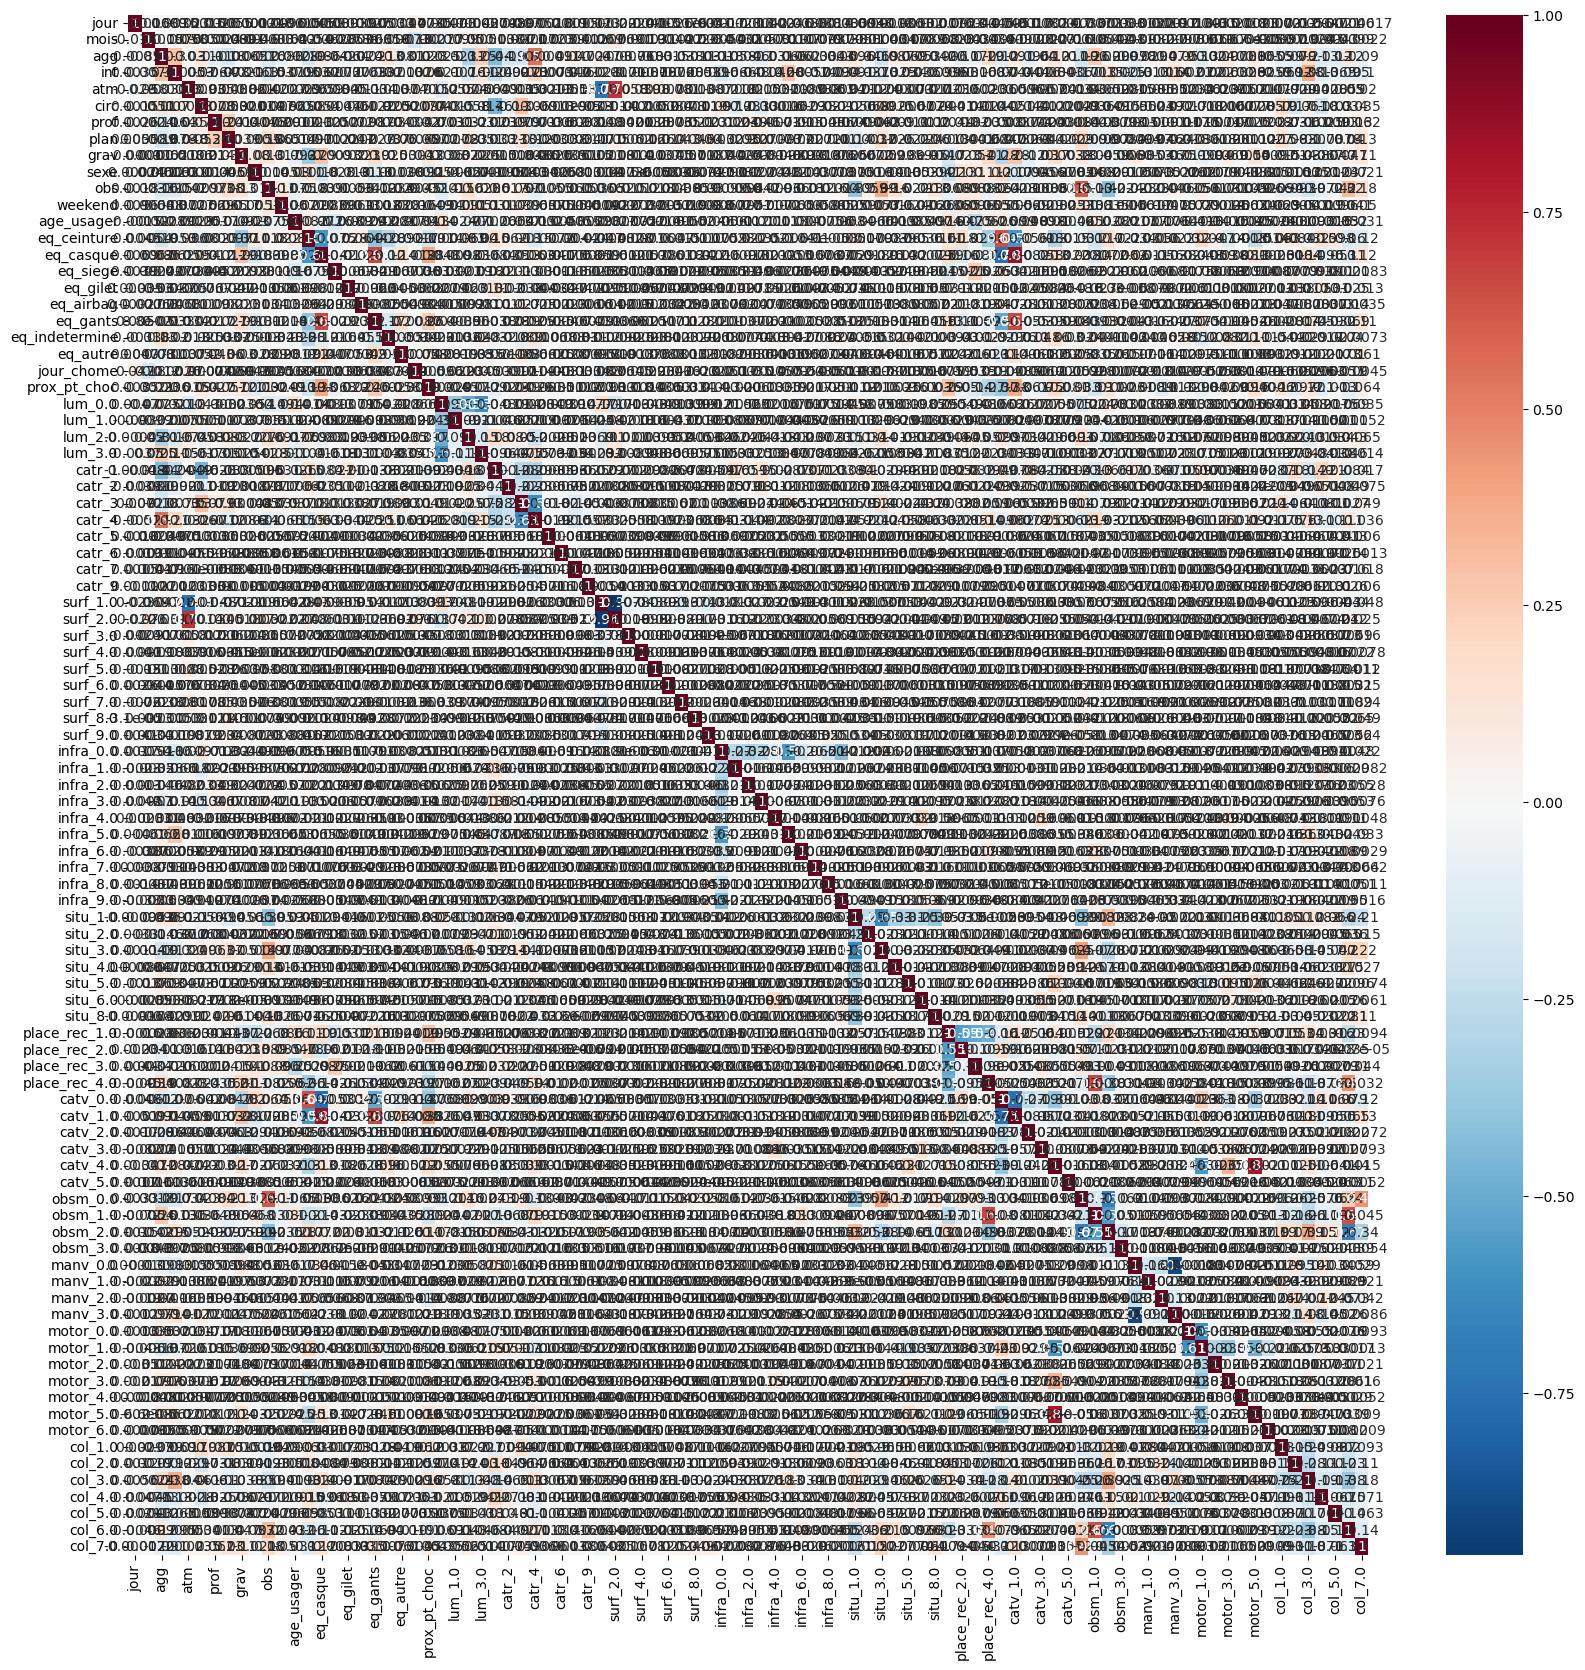

In [7]:
col_a_eliminer = ['grav_rec', 'date', 'heure', 'lat', 'long']
correlation=data_cleaned.loc[:, data_cleaned.columns.drop(col_a_eliminer)].corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation,annot=True,center=0,cmap='RdBu_r');

# Relations entre les nouvelles variables "Equipements de sécurité" et la variable cible

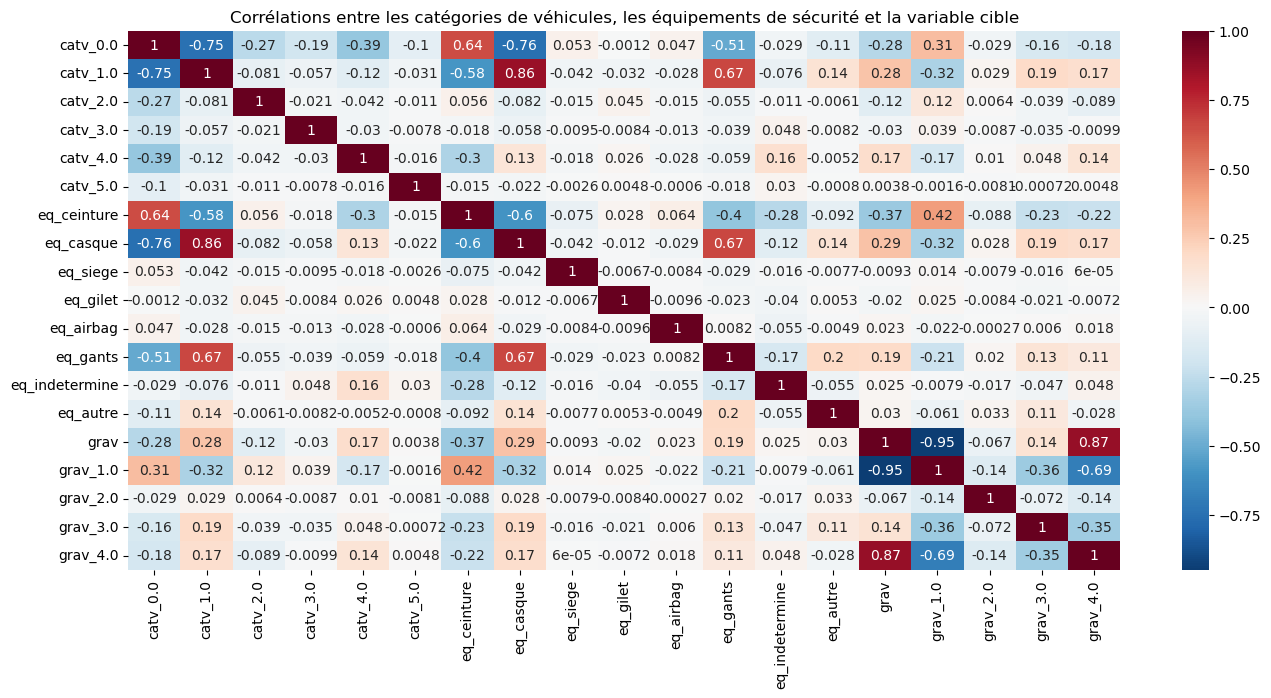

In [8]:
data_cleaned_dumm = data_cleaned.join(pd.get_dummies(data_cleaned.grav, prefix = 'grav'))

cols = data_cleaned_dumm.columns[data_cleaned_dumm.columns.str.contains('catv')]
cols = cols.append(data_cleaned_dumm.columns[data_cleaned_dumm.columns.str.contains('eq')])
cols = cols.append(data_cleaned_dumm.columns[data_cleaned_dumm.columns.str.contains('grav')])
cols = cols.drop('grav_rec')

correlation=data_cleaned_dumm.loc[:, cols].corr()
plt.figure(figsize=(16,7))
sns.heatmap(correlation,annot=True,center=0,cmap='RdBu_r');
plt.title('Corrélations entre les catégories de véhicules, les équipements de sécurité et la variable cible');

Le port de la ceinture a une influence importante sur la variable cible, en étant positivement corrélée au fait d’être indemne, et négativement corrélée au fait d’être blessé (léger ou hospitalisé). Les résultats sont inversés sur le port du casque, ce qui est relativement contre-intuitif. 
Les variables sur les équipements sont assez logiquement fortement corrélées à certaines modalités des catégories de véhicules : le port de la ceinture est positivement corrélé à la catégorie des voitures (0) et négativement corrélé à la catégorie des motos (1), tandis que c’est l’inverse pour le port du casque ou de gants. 

In [9]:
liste_stat = []
for i in cols:

    stat, p = chi2_contingency(pd.crosstab(data_cleaned_dumm["grav"], data_cleaned_dumm[i]))[:2]
    a = data_cleaned_dumm["grav"].nunique()
    b = data_cleaned_dumm[i].nunique()

    V_Cramer = np.sqrt(stat/(pd.crosstab(data_cleaned_dumm["grav"], data_cleaned_dumm[i]).values.sum()*(np.min([a, b]) - 1)))

    liste_stat.append([i, stat, p, V_Cramer])
stat_tot = pd.DataFrame(liste_stat, columns=['nom_var', 'stat_chi2', 'p_value', 'V_cramer'])
stat_tot = stat_tot.set_index('nom_var').sort_values(by='V_cramer', ascending=False)
stat_tot[5:]

stat_chi2        p_value  V_cramer
nom_var                                              
eq_ceinture     81373.065052   0.000000e+00  0.426600
eq_casque       48749.157697   0.000000e+00  0.330190
catv_1.0        47452.506631   0.000000e+00  0.325769
catv_0.0        43567.253415   0.000000e+00  0.312148
eq_gants        21807.639416   0.000000e+00  0.220843
catv_4.0        13796.027877   0.000000e+00  0.175654
catv_2.0         6206.084761   0.000000e+00  0.117812
eq_autre         5858.512260   0.000000e+00  0.114465
eq_indetermine   1598.526094   0.000000e+00  0.059792
catv_3.0          929.599697  3.361592e-201  0.045596
eq_gilet          381.522724   2.224474e-82  0.029211
eq_airbag         233.356642   2.600450e-50  0.022845
eq_siege          175.849085   6.947289e-38  0.019831
catv_5.0           35.701034   8.661436e-08  0.008936

# Relations entre la nouvelle variable "prox_pt_choc", la variable "choc", la variable recodée "place_rec" et la variable cible


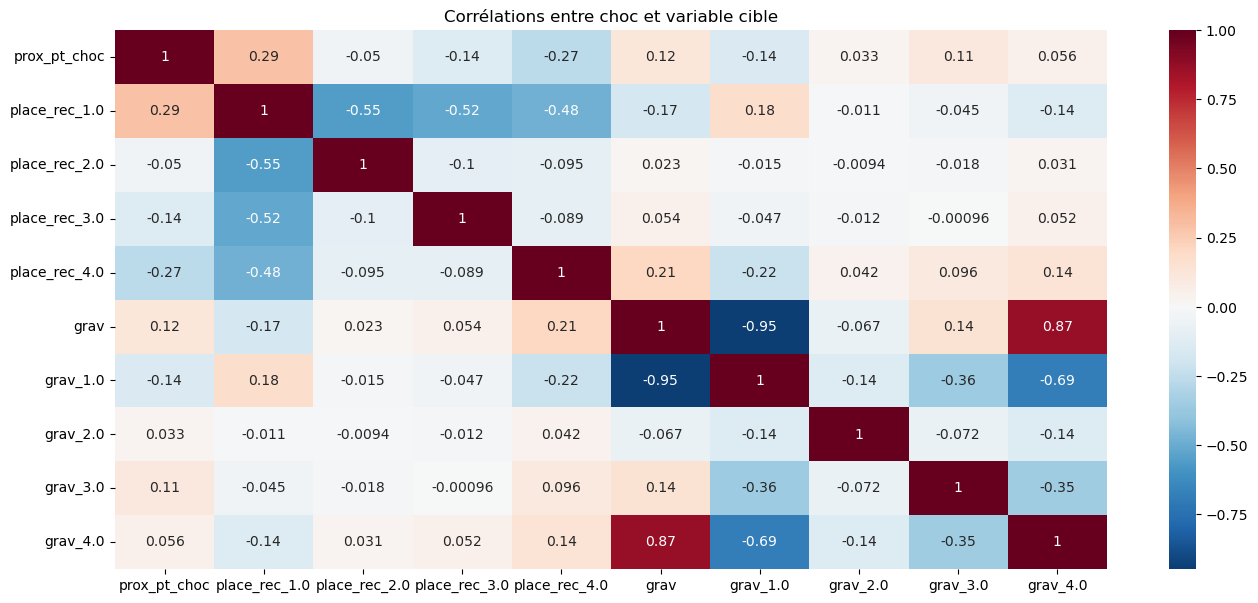

In [10]:
cols = data_cleaned_dumm.columns[data_cleaned_dumm.columns.str.contains('prox')]
cols = cols.append(data_cleaned_dumm.columns[data_cleaned_dumm.columns.str.contains('place_rec')])
cols = cols.append(data_cleaned_dumm.columns[data_cleaned_dumm.columns.str.contains('grav')])
cols = cols.drop('grav_rec')

correlation=data_cleaned_dumm.loc[:, cols].corr()
plt.figure(figsize=(16,7))
sns.heatmap(correlation,annot=True,center=0,cmap='RdBu_r');
plt.title('Corrélations entre choc et variable cible');

La proximité au point de choc est positivement corrélée (0.11) avec le fait d'être hospitalisé, et négativement corrélée (-0.14) avec le fait d'être indemne.

In [11]:
liste_stat = []
for i in cols:

    stat, p = chi2_contingency(pd.crosstab(data_cleaned_dumm["grav"], data_cleaned_dumm[i]))[:2]
    a = data_cleaned_dumm["grav"].nunique()
    b = data_cleaned_dumm[i].nunique()

    V_Cramer = np.sqrt(stat/(pd.crosstab(data_cleaned_dumm["grav"], data_cleaned_dumm[i]).values.sum()*(np.min([a, b]) - 1)))

    liste_stat.append([i, stat, p, V_Cramer])
stat_tot = pd.DataFrame(liste_stat, columns=['nom_var', 'stat_chi2', 'p_value', 'V_cramer'])
stat_tot = stat_tot.set_index('nom_var').sort_values(by='V_cramer', ascending=False)
stat_tot[5:]

stat_chi2        p_value  V_cramer
nom_var                                             
place_rec_4.0  22631.424444   0.000000e+00  0.224976
place_rec_1.0  14046.536073   0.000000e+00  0.177241
prox_pt_choc   11034.800313   0.000000e+00  0.157095
place_rec_3.0   1353.501966  3.620533e-293  0.055019
place_rec_2.0    477.481651  3.618279e-103  0.032678

In [12]:
pd.crosstab(data_cleaned.prox_pt_choc, data_cleaned.grav_rec, normalize='columns')

grav_rec      Blessé hospitalisé  Blessé léger  Indemne       Tué
prox_pt_choc                                                     
0                       0.268604      0.355711  0.47269  0.292025
1                       0.731396      0.644289  0.52731  0.707975

# Relation entre les conditions atmosphériques et la variable cible

In [13]:
data_cleaned_dumm = data_cleaned.join(pd.get_dummies(data_cleaned.grav, prefix = 'grav'))

cols = data_cleaned_dumm.columns[data_cleaned_dumm.columns.str.contains('atm')]
cols = cols.append(data_cleaned_dumm.columns[data_cleaned_dumm.columns.str.contains('grav')])
cols = cols.drop('grav_rec')

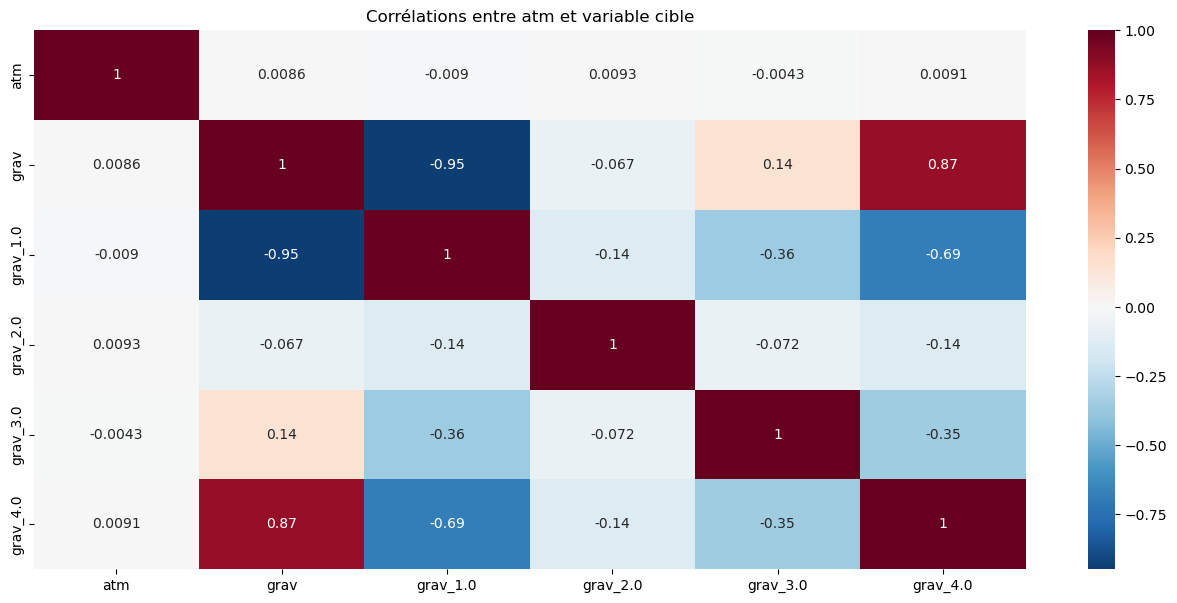

In [14]:
correlation=data_cleaned_dumm.loc[:, cols].corr()
plt.figure(figsize=(16,7))
sns.heatmap(correlation,annot=True,center=0,cmap='RdBu_r');
plt.title('Corrélations entre atm et variable cible');

In [15]:
liste_stat = []
for i in cols:

    stat, p = chi2_contingency(pd.crosstab(data_cleaned_dumm["grav"], data_cleaned_dumm[i]))[:2]
    a = data_cleaned_dumm["grav"].nunique()
    b = data_cleaned_dumm[i].nunique()

    V_Cramer = np.sqrt(stat/(pd.crosstab(data_cleaned_dumm["grav"], data_cleaned_dumm[i]).values.sum()*(np.min([a, b]) - 1)))

    liste_stat.append([i, stat, p, V_Cramer])
stat_tot = pd.DataFrame(liste_stat, columns=['nom_var', 'stat_chi2', 'p_value', 'V_cramer'])
stat_tot = stat_tot.set_index('nom_var').sort_values(by='V_cramer', ascending=False)
stat_tot[5:]

stat_chi2       p_value  V_cramer
nom_var                                   
atm      87.500705  7.538590e-19  0.013989

# Relation entre la manoeuvre principale avant l'accident et la variable cible

In [16]:
cols = data_cleaned.columns[data_cleaned.columns.str.contains('manv')]
cols = cols.append(data_cleaned.columns[data_cleaned.columns == 'grav'])
cols

Index(['manv_0.0', 'manv_1.0', 'manv_2.0', 'manv_3.0', 'grav'], dtype='object')

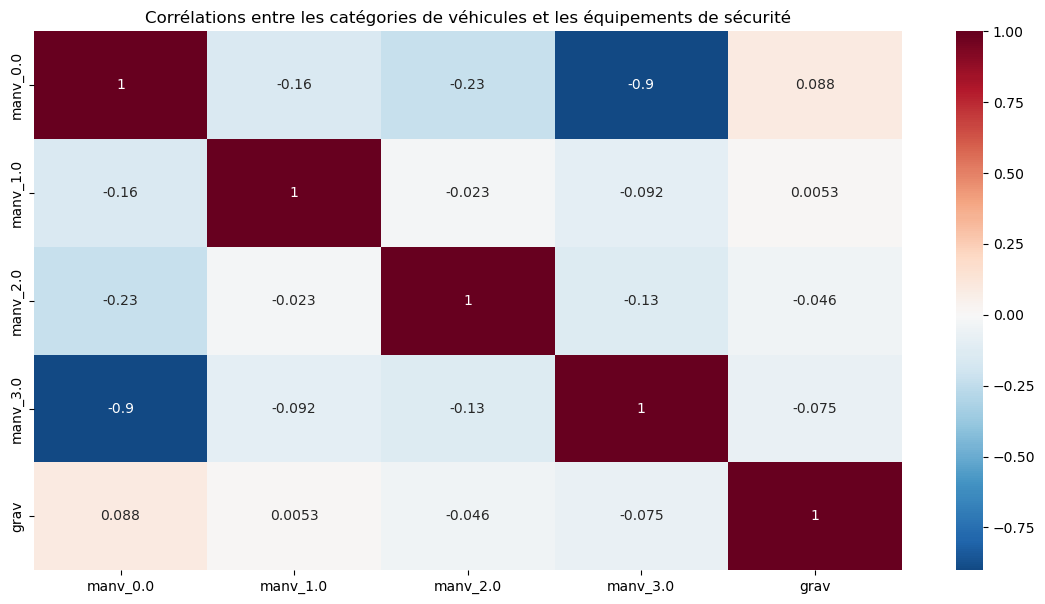

In [17]:
correlation=data_cleaned.loc[:, cols].corr()

plt.figure(figsize=(14,7))
sns.heatmap(correlation,annot=True,center=0,cmap='RdBu_r');
plt.title('Corrélations entre les catégories de véhicules et les équipements de sécurité');

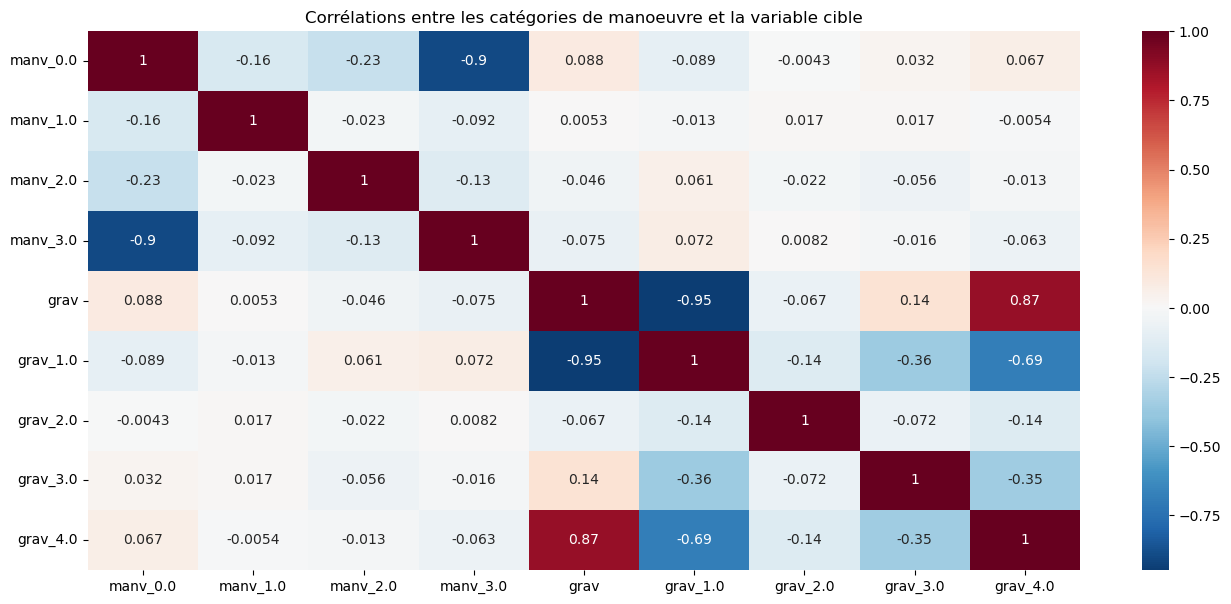

In [18]:
cols = data_cleaned_dumm.columns[data_cleaned_dumm.columns.str.contains('manv')]
cols = cols.append(data_cleaned_dumm.columns[data_cleaned_dumm.columns.str.contains('grav')])
cols = cols.drop('grav_rec')

correlation=data_cleaned_dumm.loc[:, cols].corr()
plt.figure(figsize=(16,7))
sns.heatmap(correlation,annot=True,center=0,cmap='RdBu_r');
plt.title('Corrélations entre les catégories de manoeuvre et la variable cible');

In [19]:
liste_stat = []
for i in cols:

    stat, p = chi2_contingency(pd.crosstab(data_cleaned_dumm["grav"], data_cleaned_dumm[i]))[:2]
    a = data_cleaned_dumm["grav"].nunique()
    b = data_cleaned_dumm[i].nunique()

    V_Cramer = np.sqrt(stat/(pd.crosstab(data_cleaned_dumm["grav"], data_cleaned_dumm[i]).values.sum()*(np.min([a, b]) - 1)))

    liste_stat.append([i, stat, p, V_Cramer])
stat_tot = pd.DataFrame(liste_stat, columns=['nom_var', 'stat_chi2', 'p_value', 'V_cramer'])
stat_tot = stat_tot.set_index('nom_var').sort_values(by='V_cramer', ascending=False)
stat_tot[5:]

stat_chi2       p_value  V_cramer
nom_var                                      
manv_0.0  3658.213423  0.000000e+00  0.090451
manv_3.0  2528.445404  0.000000e+00  0.075198
manv_2.0  2448.893490  0.000000e+00  0.074006
manv_1.0   294.418788  1.605695e-63  0.025660

# Relation entre jour_semaine et gravité

In [20]:
data_cleaned['date'] = pd.to_datetime(data_cleaned['date'])
data_cleaned['jour_semaine'] = data_cleaned['date'].dt.weekday
data_cleaned['jour_semaine'].value_counts()


jour_semaine
1    77306
4    74167
2    64481
0    62848
5    58072
3    56786
6    53476
Name: count, dtype: int64

In [21]:
data_cleaned = data_cleaned.join(pd.get_dummies(data_cleaned['jour_semaine'], prefix = 'jour'))
data_cleaned =data_cleaned.replace(True, 1)
data_cleaned =data_cleaned.replace(False, 0)
    
data_cleaned.head()

jour  mois  agg  int  atm        lat      long  circ  prof  plan  ...  \
0    30    11    0  0.0  0.0  48.896210  2.470120   0.0   0.0   1.0  ...   
1    30    11    0  0.0  0.0  48.896210  2.470120   0.0   0.0   1.0  ...   
2    30    11    0  0.0  0.0  48.896210  2.470120   0.0   0.0   1.0  ...   
3    30    11    0  0.0  0.0  48.930700  2.368800   0.0   1.0   1.0  ...   
4    28    11    0  0.0  0.0  48.935872  2.319174   0.0   0.0   1.0  ...   

   col_6.0  col_7.0  jour_semaine jour_0 jour_1  jour_2  jour_3  jour_4  \
0        0        0             4      0      0       0       0       1   
1        0        0             4      0      0       0       0       1   
2        0        0             4      0      0       0       0       1   
3        1        0             4      0      0       0       0       1   
4        0        0             4      0      0       0       0       1   

   jour_5  jour_6  
0       0       0  
1       0       0  
2       0       0  
3       0       0  
4       0       0  

[5 rows x 106 columns]

In [22]:
cols = data_cleaned.columns[data_cleaned.columns.str.contains('jour_')]
cols = cols.append(data_cleaned.columns[data_cleaned.columns == 'grav'])
cols = cols.drop('jour_chome')
cols

Index(['jour_semaine', 'jour_0', 'jour_1', 'jour_2', 'jour_3', 'jour_4',
       'jour_5', 'jour_6', 'grav'],
      dtype='object')

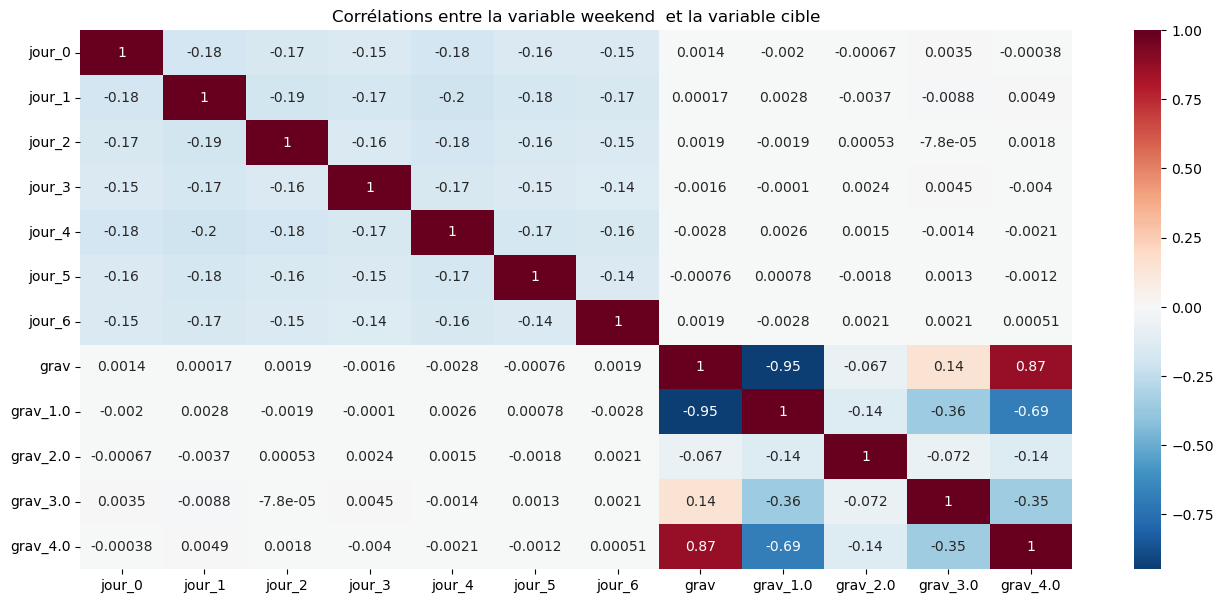

In [23]:
data_cleaned_dumm = data_cleaned.join(pd.get_dummies(data_cleaned.grav, prefix = 'grav'))

cols = data_cleaned_dumm.columns[data_cleaned_dumm.columns.str.contains('jour_semaine')]
cols = cols.append(data_cleaned_dumm.columns[data_cleaned_dumm.columns.str.contains('jour_')])
cols = cols.append(data_cleaned_dumm.columns[data_cleaned_dumm.columns.str.contains('grav')])
cols = cols.drop(['grav_rec', 'jour_chome', 'jour_semaine'])

correlation=data_cleaned_dumm.loc[:, cols].corr()
plt.figure(figsize=(16,7))
sns.heatmap(correlation,annot=True,center=0,cmap='RdBu_r');
plt.title('Corrélations entre la variable weekend  et la variable cible');

In [24]:
liste_stat = []
for i in cols:

    stat, p = chi2_contingency(pd.crosstab(data_cleaned_dumm["grav"], data_cleaned_dumm[i]))[:2]
    a = data_cleaned_dumm["grav"].nunique()
    b = data_cleaned_dumm[i].nunique()

    V_Cramer = np.sqrt(stat/(pd.crosstab(data_cleaned_dumm["grav"], data_cleaned_dumm[i]).values.sum()*(np.min([a, b]) - 1)))

    liste_stat.append([i, stat, p, V_Cramer])
stat_tot = pd.DataFrame(liste_stat, columns=['nom_var', 'stat_chi2', 'p_value', 'V_cramer'])
stat_tot = stat_tot.set_index('nom_var').sort_values(by='V_cramer', ascending=False)
stat_tot[5:]

stat_chi2       p_value  V_cramer
nom_var                                   
jour_1   43.835374  1.635726e-09  0.009901
jour_3   14.384992  2.425307e-03  0.005672
jour_0    6.041107  1.096273e-01  0.003676
jour_6    5.787469  1.224208e-01  0.003598
jour_4    4.658266  1.986004e-01  0.003228
jour_5    2.636677  4.510958e-01  0.002428
jour_2    1.863872  6.011352e-01  0.002042

# Relation entre weekend et vendredi_weekend avec la variable cible

### weekend

In [25]:
cols = data_cleaned.columns[data_cleaned.columns.str.contains('weekend')]
cols = cols.append(data_cleaned.columns[data_cleaned.columns == 'grav'])
cols

Index(['weekend', 'grav'], dtype='object')

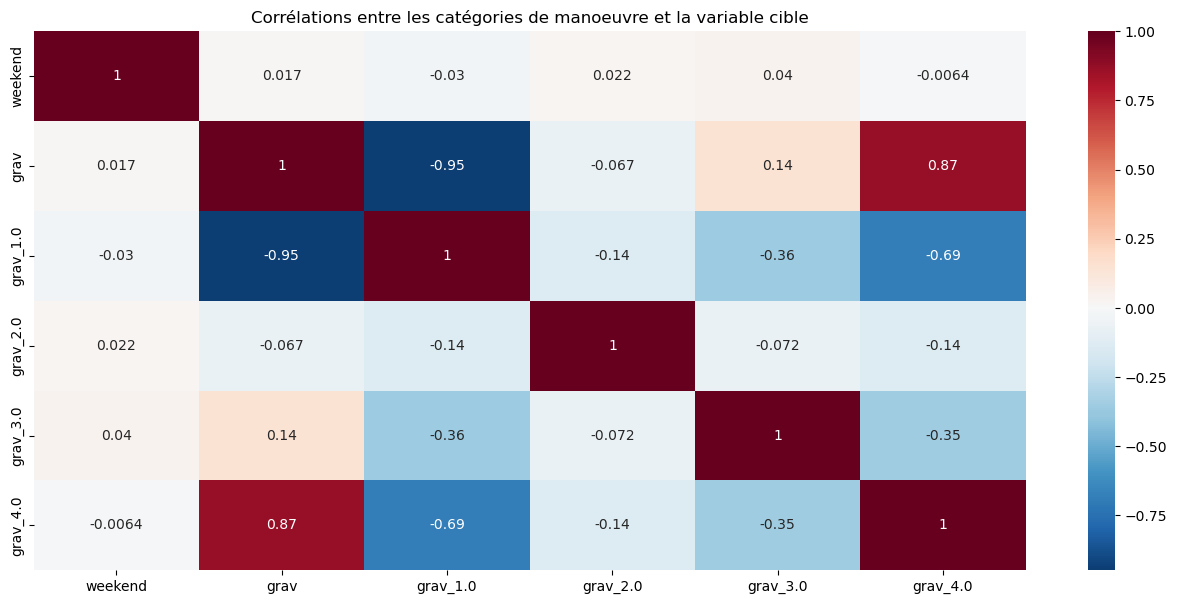

In [26]:
cols = data_cleaned_dumm.columns[data_cleaned_dumm.columns.str.contains('weekend')]
cols = cols.append(data_cleaned_dumm.columns[data_cleaned_dumm.columns.str.contains('grav')])
cols = cols.drop('grav_rec')

correlation=data_cleaned_dumm.loc[:, cols].corr()
plt.figure(figsize=(16,7))
sns.heatmap(correlation,annot=True,center=0,cmap='RdBu_r');
plt.title('Corrélations entre les catégories de manoeuvre et la variable cible');

In [27]:
liste_stat = []
for i in cols:

    stat, p = chi2_contingency(pd.crosstab(data_cleaned_dumm["grav"], data_cleaned_dumm[i]))[:2]
    a = data_cleaned_dumm["grav"].nunique()
    b = data_cleaned_dumm[i].nunique()

    V_Cramer = np.sqrt(stat/(pd.crosstab(data_cleaned_dumm["grav"], data_cleaned_dumm[i]).values.sum()*(np.min([a, b]) - 1)))

    liste_stat.append([i, stat, p, V_Cramer])
stat_tot = pd.DataFrame(liste_stat, columns=['nom_var', 'stat_chi2', 'p_value', 'V_cramer'])
stat_tot = stat_tot.set_index('nom_var').sort_values(by='V_cramer', ascending=False)
stat_tot[5:]

stat_chi2        p_value  V_cramer
nom_var                                      
weekend  1057.571219  5.832204e-229  0.048633

### vendredi_weekend

In [28]:
# création d'une variable vendredi_weekend à partir du jour de la semaine (Friday is 4, Saturday is 5 and Sunday is 6)
data_cleaned['date'] = pd.to_datetime(data_cleaned['date'])
data_cleaned['vendredi_weekend'] = data_cleaned['date'].dt.weekday.apply(lambda x: 1 if x >= 4 else 0)
data_cleaned['vendredi_weekend'].value_counts()

vendredi_weekend
0    261421
1    185715
Name: count, dtype: int64

In [29]:
cols = data_cleaned.columns[data_cleaned.columns.str.contains('vendredi_weekend')]
cols = cols.append(data_cleaned.columns[data_cleaned.columns == 'grav'])
cols

Index(['vendredi_weekend', 'grav'], dtype='object')

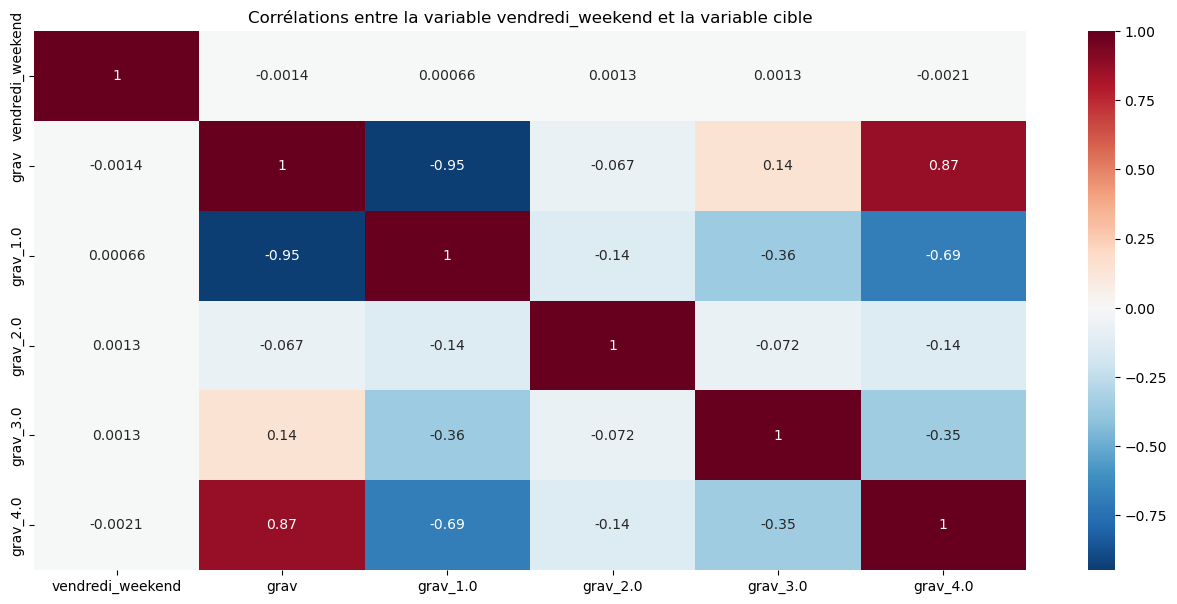

In [30]:
data_cleaned_dumm = data_cleaned.join(pd.get_dummies(data_cleaned.grav, prefix = 'grav'))

cols = data_cleaned_dumm.columns[data_cleaned_dumm.columns.str.contains('vendredi_weekend')]
cols = cols.append(data_cleaned_dumm.columns[data_cleaned_dumm.columns.str.contains('grav')])
cols = cols.drop('grav_rec')

correlation=data_cleaned_dumm.loc[:, cols].corr()
plt.figure(figsize=(16,7))
sns.heatmap(correlation,annot=True,center=0,cmap='RdBu_r');
plt.title('Corrélations entre la variable vendredi_weekend et la variable cible');

In [31]:
liste_stat = []
for i in cols:

    stat, p = chi2_contingency(pd.crosstab(data_cleaned_dumm["grav"], data_cleaned_dumm[i]))[:2]
    a = data_cleaned_dumm["grav"].nunique()
    b = data_cleaned_dumm[i].nunique()

    V_Cramer = np.sqrt(stat/(pd.crosstab(data_cleaned_dumm["grav"], data_cleaned_dumm[i]).values.sum()*(np.min([a, b]) - 1)))

    liste_stat.append([i, stat, p, V_Cramer])
stat_tot = pd.DataFrame(liste_stat, columns=['nom_var', 'stat_chi2', 'p_value', 'V_cramer'])
stat_tot = stat_tot.set_index('nom_var').sort_values(by='V_cramer', ascending=False)
stat_tot[5:]

stat_chi2   p_value  V_cramer
nom_var                                        
vendredi_weekend   2.605329  0.456556  0.002414

# Relation entre jour_chome avec la variable cible

In [32]:
cols = data_cleaned.columns[data_cleaned.columns.str.contains('jour_chome')]
cols = cols.append(data_cleaned.columns[data_cleaned.columns == 'grav'])
cols

Index(['jour_chome', 'grav'], dtype='object')

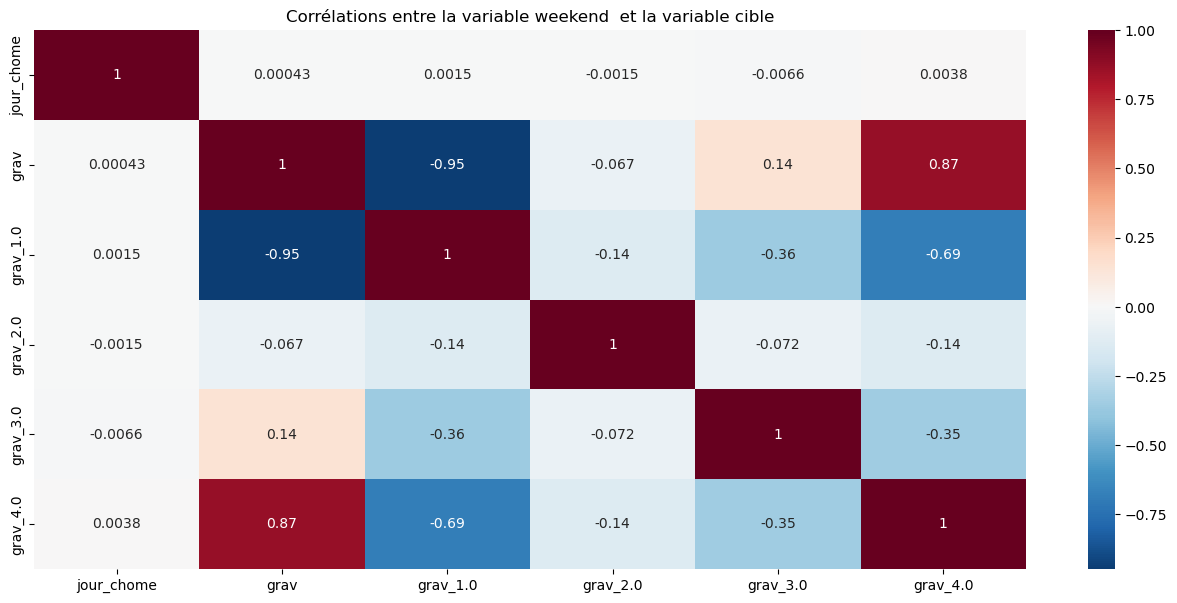

In [33]:
data_cleaned_dumm = data_cleaned.join(pd.get_dummies(data_cleaned.grav, prefix = 'grav'))

cols = data_cleaned_dumm.columns[data_cleaned_dumm.columns.str.contains('jour_chome')]
cols = cols.append(data_cleaned_dumm.columns[data_cleaned_dumm.columns.str.contains('grav')])
cols = cols.drop('grav_rec')

correlation=data_cleaned_dumm.loc[:, cols].corr()
plt.figure(figsize=(16,7))
sns.heatmap(correlation,annot=True,center=0,cmap='RdBu_r');
plt.title('Corrélations entre la variable weekend  et la variable cible');

In [34]:
liste_stat = []
for i in cols:

    stat, p = chi2_contingency(pd.crosstab(data_cleaned_dumm["grav"], data_cleaned_dumm[i]))[:2]
    a = data_cleaned_dumm["grav"].nunique()
    b = data_cleaned_dumm[i].nunique()

    V_Cramer = np.sqrt(stat/(pd.crosstab(data_cleaned_dumm["grav"], data_cleaned_dumm[i]).values.sum()*(np.min([a, b]) - 1)))

    liste_stat.append([i, stat, p, V_Cramer])
stat_tot = pd.DataFrame(liste_stat, columns=['nom_var', 'stat_chi2', 'p_value', 'V_cramer'])
stat_tot = stat_tot.set_index('nom_var').sort_values(by='V_cramer', ascending=False)
stat_tot[5:]

stat_chi2   p_value  V_cramer
nom_var                                  
jour_chome  21.745782  0.000074  0.006974

# Comparaison de la variable gravité avant et après traitement

In [35]:
data_initial = pd.read_csv(conf['local_data_path'] + "accidents.csv",sep = ";", index_col=0,low_memory=False)

C:\Users\dcons\AppData\Local\Temp\ipykernel_28352\3363857220.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121);


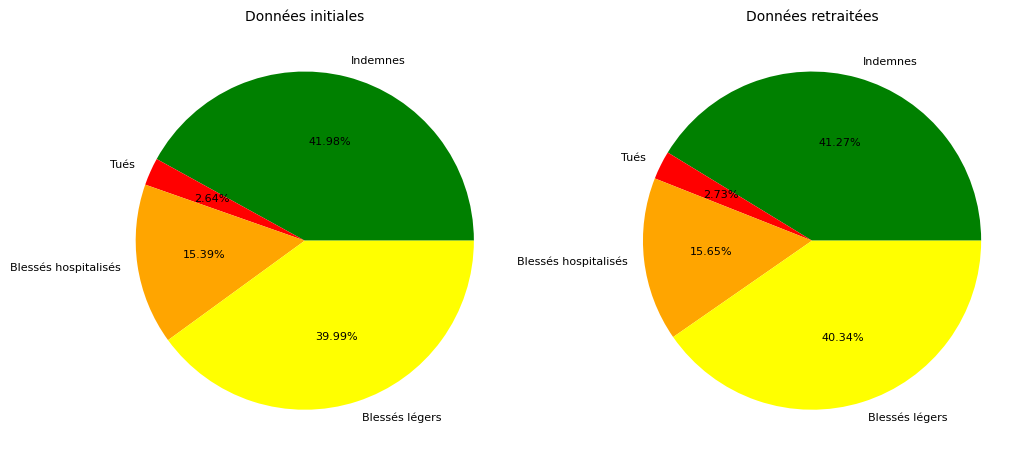

In [36]:
grav_label = ['Indemnes', 'Tués', 'Blessés hospitalisés', 'Blessés légers']

plt.figure(figsize = (12, 7))
plt.title('Proportion de chaque modalité de gravité selon le jeu de donnée', fontdict={'fontsize' : 14})
plt.axis('off');

plt.subplot(121);
plt.title("Données initiales", fontsize=10);
plt.pie(data_initial.groupby(['grav']).size(), labels =  grav_label, colors = ['g', 'r', 'orange', 'yellow'], labeldistance = 1.1,
       autopct=lambda x:str(round(x, 2))+'%', textprops={'fontsize':8});
plt.subplot(122);
plt.title("Données retraitées", fontsize=10);
plt.pie(data_cleaned.groupby(['grav']).size(), labels =  grav_label, colors = ['g', 'r', 'orange', 'yellow'], labeldistance = 1.1,
       autopct=lambda x:str(round(x, 2))+'%', textprops={'fontsize':8});